# Distance between origins and destinations

Sam Maurer

This notebook uses OSMNx and NetworkX to calculate the shortest path between each origin and each destination in a list, and then pare down the combinations to highlight the closest.  
https://github.com/gboeing/osmnx-examples/tree/master/notebooks  
https://networkx.github.io/documentation/stable/reference/algorithms/shortest_paths.html

Pandana is another library to look into, but it's optimized for *counting destinations within a certain distance buffer* rather than finding shortest paths per se, so it may not be very helpful.  
http://udst.github.io/pandana/tutorial.html

## 1. Set up a street network graph and some origins and destinations

In [1]:
%%capture
!pip install osmnx

In [2]:
import numpy as np
import pandas as pd
import osmnx

### a. Get a street network

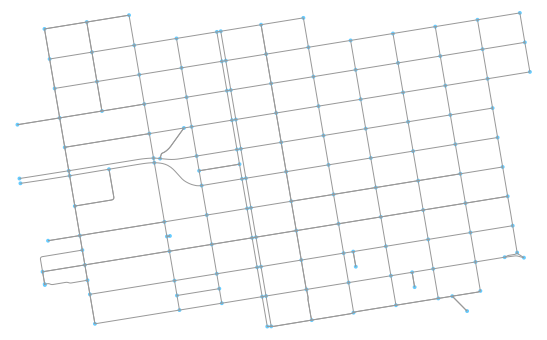

In [3]:
north, south, east, west = 37.79, 37.78, -122.41, -122.43

# create network from that bounding box
G = osmnx.graph_from_bbox(north, south, east, west, network_type='drive')

fig, ax = osmnx.plot_graph(osmnx.project_graph(G))
fig.show()

https://networkx.github.io/documentation/networkx-1.10/reference/classes.multidigraph.html

You can do things like `list(G.nodes)` or `list(G.edges)` to see what the data looks like, or  
`gdf_nodes, gdf_edges = osmnx.graph_to_gdfs(G)`.

### b. Get some origin and destination points

In [4]:
def random_point(north, south, east, west):
    """
    Generate a random point within a bounding box.
    
    """
    x = (east - west) * np.random.random() + west
    y = (north - south) * np.random.random() + south
    return (x, y)

In [5]:
# Generate some origins, randomly distributed across the neighborhood

x_list = []
y_list = []

for i in range(4):
    x, y = random_point(37.79, 37.78, -122.41, -122.43)
    x_list.append(x)
    y_list.append(y)

orig_df = pd.DataFrame({'x': x_list, 'y': y_list})
orig_df

,x,y
0,-122.422255,37.788818
1,-122.410442,37.782610
2,-122.411088,37.786931
3,-122.410388,37.784808


In [6]:
# Generate some destinations, all in the western half

x_list = []
y_list = []

for i in range(4):
    x, y = random_point(37.79, 37.78, -122.42, -122.43)
    x_list.append(x)
    y_list.append(y)

dest_df = pd.DataFrame({'x': x_list, 'y': y_list})
dest_df

,x,y
0,-122.425653,37.780962
1,-122.420542,37.783428
2,-122.426729,37.785791
3,-122.428638,37.782149


## 2. Shortest paths with OSMNx

Using OSMNx (+ NetworkX and Pandas), you can
- associate each point with the nearest node
- calculate a path from all the origins to all the destinations (this can be slow)
- then, pare down the combinations however you want

### a. First, associate each origin/destination point with the closest node (intersection) in the network

We'll make a new column in the DataFrame for this, and apply a row-wise function.

In [7]:
def nearest_node(row):
    return osmnx.get_nearest_node(G, (row.y, row.x))

orig_df['orig_node'] = orig_df.apply(nearest_node, axis=1)  # axis=1 means do row-wise calculations (not column-wise)

orig_df

,x,y,orig_node
0,-122.422255,37.788818,65319966
1,-122.410442,37.782610,3814451006
2,-122.411088,37.786931,65334120
3,-122.410388,37.784808,65333814


In [8]:
dest_df['dest_node'] = dest_df.apply(nearest_node, axis=1)

dest_df

,x,y,dest_node
0,-122.425653,37.780962,276546821
1,-122.420542,37.783428,258758553
2,-122.426729,37.785791,65338344
3,-122.428638,37.782149,65292717


### b. Make a new dataframe with every combination of origin and destination

In [9]:
orig_list = []
dest_list = []

for o in orig_df.orig_node:
    for d in dest_df.dest_node:
        orig_list.append(o)
        dest_list.append(d)

all_ods = pd.DataFrame({'o_node': orig_list, 'd_node': dest_list})

all_ods

,o_node,d_node
0,65319966,276546821
1,65319966,258758553
2,65319966,65338344
3,65319966,65292717
4,3814451006,276546821
5,3814451006,258758553
6,3814451006,65338344
7,3814451006,65292717
8,65334120,276546821
9,65334120,258758553


### c. Calculate the shortest paths

Note that NetworkX works with all kinds of networks, not just streets -- so you have to specify that you want the shortest path to take into account the "length" of each edge. Otherwise it will just find the path with the fewest intermediate nodes.

The units will be whatever the lengths are that come out of OSM -- presumably meters, but i haven't verified!

In [10]:
import networkx as nx

In [11]:
def distance(row):
    return nx.shortest_path_length(G, source=row.o_node, target=row.d_node, weight='length')

all_ods['dist'] = all_ods.apply(distance, axis=1)

all_ods

,o_node,d_node,dist
0,65319966,276546821,1312.944
1,65319966,258758553,747.826
2,65319966,65338344,1026.381
3,65319966,65292717,1350.817
4,3814451006,276546821,1559.249
5,3814451006,258758553,1176.436
6,3814451006,65338344,2114.906
7,3814451006,65292717,1810.353
8,65334120,276546821,1882.946
9,65334120,258758553,1081.229


### d. Pare down the combinations

For example, here's the destination closest to each origin:

In [12]:
all_ods.sort_values('dist').drop_duplicates('o_node')

,o_node,d_node,dist
1,65319966,258758553,747.826
13,65333814,258758553,871.223
9,65334120,258758553,1081.229
5,3814451006,258758553,1176.436
